In [20]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [21]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
PATH = "datasets/HPA_challenge_2018/"
data_path = Path(PATH)

In [51]:
NUM_CLASSES = 28
bs = 128
sz = [4,224,224]

In [52]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'HPA_labels.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n, val_pct=0.1)

In [53]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'train_BGYR_all', lbl_csv, val_idxs = val_idxs, test_name='test_BGYR_all', tfms=tfms, bs=bs, suffix = '.tiff', 
                                        balance=True)
    
    return data

In [35]:
!ls datasets/HPA_challenge_2018

HPA_labels.csv	       test-raw  test_BGYR_all	train.zip	train_raw
sample_submission.csv  test.zip  train.csv	train_BGYR_all


In [54]:
# define augmentations
augs = [RandomDihedral()]

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

weighted


### inpsect data_loaders

In [55]:
x, y = next(iter(data.trn_dl))
# x_test, y_test = next(iter(data.test_dl))

In [38]:
y.sum(dim=0)


 28
  1
  2
  3
  3
  3
  2
  4
  3
  2
  3
  2
 11
  1
  6
  4
  3
  0
 13
  1
  3
  4
  2
  6
  1
  5
  4
  5
[torch.cuda.FloatTensor of size 28 (GPU 0)]

In [ ]:
# loading epochs to inspect class-balance

In [39]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


In [40]:
xs, ys = load_epoch()

In [41]:
# analyze results
lbl_dist = ys.sum(axis=0)
print(lbl_dist)

[214.  27.  34.  22.  30.  21.  42.  23.  42.  34.  27.  41.  55.  25.  45.  25.  45.  27. 112.  23.  20.
  24.  30.  50.  45.  36.  25.  44.]


In [ ]:
# weights calculation WIP

# ys = data.trn_ds.y

# cut = 1/len(data.classes)
# perc = (ys.sum(axis=0) / ys.sum())

# weights_per_label = [cut / perc[i] for i in range(len(data.classes))]
# w_matrix = [ys[i] * weights_per_label for i in range(len(ys))]

# min_weights_per_im = [np.min(w_matrix[i][np.nonzero(w_matrix[i])]) for i in range(len(ys))]
# weights_per_im = [np.max(w_matrix[i]) for i in range(len(ys))]

In [ ]:
# min_weights_per_im[:10]

### inpsecting loaded images and labels

In [47]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

[0, 14, 15]


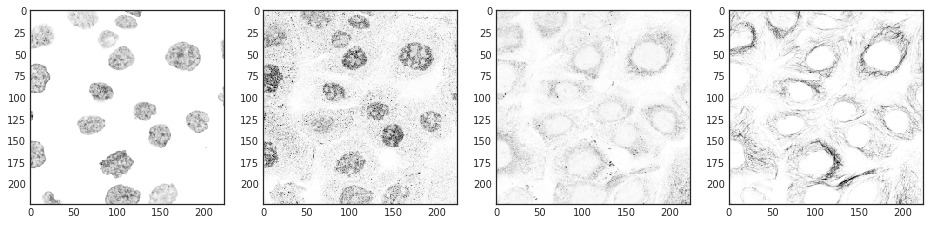

In [48]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [42]:
torch.cuda.is_available()

True

In [75]:
# base-model
# 
# arch = resnet18_c
arch = resnet34_c

learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [76]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [77]:
learn.unfreeze()

In [59]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 5

In [60]:
learn.lr_find()

 84%|████████▍ | 185/219 [06:04<01:17,  2.27s/it, loss=1.27] 

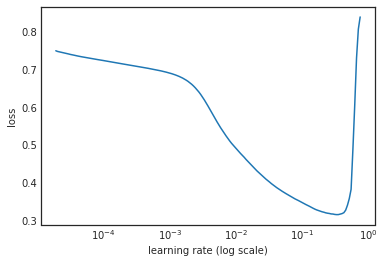

In [61]:
learn.sched.plot()

In [ ]:
# training loops:

In [ ]:
%time learn.fit(5e-3, 8, cycle_len=1, wds=wd, use_wd_sched=True)

In [62]:
%time learn.fit(5e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 0      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.20334    0.225681   0.936215   0.04696   
EPOCH 1 ---------------------------------------- STEP 1      
    1      0.172401   0.188474   0.939537   0.067092  
EPOCH 2 ---------------------------------------- STEP 2      
    2      0.157484   0.172887   0.944457   0.092349  
EPOCH 3 ---------------------------------------- STEP 3      
    3      0.137469   0.152268   0.949641   0.171092  
EPOCH 4 ---------------------------------------- STEP 4      
    4      0.124736   0.14329    0.95094    0.218053  
EPOCH 5 ---------------------------------------- STEP 5      
    5      0.117997   0.145082   0.948618   0.230367  
EPOCH 6 ---------------------------------------- STEP 6      
    6      0.106526   0.143078   0.950986   0.255001  
EPOCH 7 ---------------------------------------- STEP 7       
    7      0.098128   0.12386    0.955952   0.308923  
EPOCH 8

[array([0.11601]), 0.9584923394055546, 0.37502844254801626]

In [63]:
%time learn.fit(5e-4, 1, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='AWS_Res34_BGYR_v1')

EPOCH 0 ---------------------------------------- STEP 16      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.072572   0.120558   0.957389   0.368763  
EPOCH 1 ---------------------------------------- STEP 17      
    1      0.070415   0.11503    0.958998   0.382459  
EPOCH 2 ---------------------------------------- STEP 18      
    2      0.067922   0.111517   0.960446   0.389458  
EPOCH 3 ---------------------------------------- STEP 19      
    3      0.065336   0.12234    0.959711   0.386765  
EPOCH 4 ---------------------------------------- STEP 20      
    4      0.063952   0.117466   0.960102   0.392135  
EPOCH 5 ---------------------------------------- STEP 21      
    5      0.06019    0.126533   0.959423   0.39464   
EPOCH 6 ---------------------------------------- STEP 22      
    6      0.059193   0.127575   0.960159   0.400049  
EPOCH 7 ---------------------------------------- STEP 23      
    7      0.057312   0.117743   0.960768   0.404254  


[array([0.11774]), 0.9607683127241807, 0.40425367320562083]

In [66]:
%time learn.fit(1e-4, 1, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='AWS_Res34_BGYR_v1.3')

EPOCH 0 ---------------------------------------- STEP 26      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.056766   0.112397   0.961228   0.404115  
EPOCH 1 ---------------------------------------- STEP 27      
    1      0.054306   0.122951   0.96086    0.402681  
EPOCH 2 ---------------------------------------- STEP 28      
    2      0.053345   0.11851    0.961366   0.408019  
EPOCH 3 ---------------------------------------- STEP 29      
    3      0.052326   0.118472   0.961389   0.407945  
EPOCH 4 ---------------------------------------- STEP 30      
    4      0.051743   0.120407   0.960688   0.402694  
EPOCH 5 ---------------------------------------- STEP 31      
    5      0.050576   0.115352   0.96163    0.407255  
EPOCH 6 ---------------------------------------- STEP 32      
    6      0.04942    0.126241   0.960826   0.404711  
EPOCH 7 ---------------------------------------- STEP 33      
    7      0.050319   0.119921   0.961033   0.405828  


[array([0.11992]), 0.9610326894234337, 0.40582795061119437]

In [69]:
# define augmentations
augs = [RandomDihedral()]
bs = 128
sz = [4,512,512]

# initialize data object
new_data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

weighted


In [70]:
learn.set_data(new_data)

In [72]:
%time learn.fit(1e-4, 8, cycle_len=1, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='AWS_Res34_BGYR_512_v1')

EPOCH 0 ---------------------------------------- STEP 35     
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.190412   0.145931   0.949768   0.248134  
EPOCH 1 ---------------------------------------- STEP 36     
    1      0.172896   0.136358   0.952021   0.26391   
EPOCH 2 ---------------------------------------- STEP 37     
    2      0.161805   0.132628   0.952848   0.276011  
EPOCH 3 ---------------------------------------- STEP 38     
    3      0.150437   0.13167    0.953515   0.284717  
 26%|██▌       | 57/219 [04:20<10:40,  3.96s/it, loss=0.15] 

KeyboardInterrupt: 

In [ ]:
# continue

In [73]:
# define augmentations
augs = [RandomDihedral()]
bs = 128
sz = [4,256,256]

# initialize data object
new_data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

weighted


In [74]:
learn.set_data(new_data)

In [78]:
learn.load('AWS_Res34_BGYR_v1.3')

In [81]:
learn.lr_find(1e-10)

 85%|████████▌ | 187/219 [05:19<00:51,  1.61s/it, loss=0.233] 

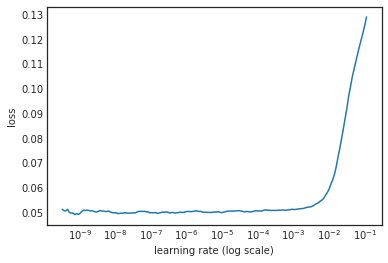

In [82]:
learn.sched.plot()

In [64]:
learn.save('AWS_Res34_BGYR_v1.1')

In [ ]:
log_preds, y = learn.predict_with_targs()

## test-predictions

In [ ]:
log_preds, y =  learn.predict_with_targs('test')

In [ ]:
# creating submission file
thresh = 0.2



clss = np.arange(0, len(data.classes)) # get class indeces
res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > thresh)])) for p in log_preds]) # generating output

# ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
for i in range(res.shape[0]):
    if res[i] == '':
        res[i] = log_preds[i].argmax()

# getting image Ids
fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

# creating submission file
sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
sub_df.to_csv(f"{PATH}submissions/Test_submission_thresh_02.csv", index_label='Id')

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }